In [ ]:
!pip install newspaper3k
!pip install pandas
!pip install matplotlib
!pip install transformers
!pip install nltk
!pip install sentencepiece
!pip install wordpiece
!pip install ipywidgets
!pip install -U scikit-learn
!pip install tqdm
!pip install pydot
# using nvidia-docker image from https://ngc.nvidia.com/catalog/containers/nvidia:tensorflow/tags
# using release 21.02-tf2-py3"

In [1]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import plot_model

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from datetime import datetime
from collections import defaultdict

from sklearn.model_selection import train_test_split



In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from transformers import TFXLNetForSequenceClassification, XLNetTokenizer

# Data Exploration

In [6]:
data = pd.read_table("biaseddata.csv", sep='\t', index_col=0)
# data = pd.read_table("processedbiasdata.csv", sep='\t', index_col=0)
data

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories
0,http://www.usatoday.com/story/news/nation/2013...,other,1,Civil Rights,Civil Rights,Neutral,Neutral,maggie clark pew SOURCE staff writer 21 states...,600,0.0,0.0,Neutral,0,0
1,http://www.huffingtonpost.com/2013/05/21/senat...,News,0,Civil Rights,Civil Rights,Neutral,Neutral,washington -- the senate judiciary committee a...,600,0.0,0.0,Neutral,0,0
2,http://www.washingtonpost.com/opinions/dont-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,david cole is a professor of constitutional la...,600,0.0,0.0,Neutral,0,0
3,http://www.foxnews.com/politics/2013/04/03/oba...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,"parts of obamacare are starting to fray, even ...",600,0.0,0.0,Neutral,0,0
4,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,u.s. immigration citizenship and immigration s...,600,0.0,0.0,Neutral,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12345,http://www.washingtonpost.com/opinions/dana-mi...,News,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,president obama won reelection in part by beat...,600,0.5,-0.5,Liberal,1,1
12346,http://news.yahoo.com/republicans-hatred-obama...,Opinion,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,"red-faced republicans, circling and preparing ...",600,0.5,-0.5,Liberal,1,1
12347,http://www.washingtonpost.com/opinions/dana-mi...,News,1,Republican Scandals,Republican Scandals,Neutral,Neutral,rep. steve stockman’s moment as a viable senat...,600,0.0,0.0,Neutral,0,0
12348,http://www.washingtonpost.com/opinions/ej-dion...,News,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,we interrupt this highly partisan and ideologi...,600,0.5,-0.5,Liberal,1,1


In [7]:
data.shape

(12350, 14)

In [8]:
# tfdf = data[['article','biaslabel']]
tfdf = data.sample(frac=1)
tfdf['text'] = data['article']
tfdf['label'] = data['biaslabel']
# tfdf['label'] = data['democrat.vote']
# tfdf = tfdf[['text','label']]
# tfdf = tfdf.sample(frac=1)
tfdf = tfdf.reset_index(drop=True)

print(tfdf.shape)
tfdf.head()

(12350, 16)


,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories,text,label
0,http://www.washingtonpost.com/politics/obama-v...,News,1,Democrat Scandals,None,SomewhatNegative,Neutral,during a joint press conference with turkish p...,600,-0.5,0.0,Somewhat Conservative,1,-1,during a joint press conference with turkish p...,Somewhat Conservative
1,http://www.huffingtonpost.com/2013/06/06/ny-ti...,News,1,Civil Rights,National Security,Negative,Neutral,the times became one of the more influential v...,285,-1.0,0.0,Conservative,1,-1,the times became one of the more influential v...,Conservative
2,http://www.foxnews.com/politics/2013/11/28/dem...,Opinion,1,Elections,Healthcare,SomewhatNegative,Neutral,a month after emerging from a government shutd...,600,-0.5,0.0,Somewhat Conservative,1,-1,a month after emerging from a government shutd...,Somewhat Conservative
3,http://www.foxnews.com/opinion/2013/04/23/immi...,Opinion,0,Civil Rights,None,SomewhatNegative,SomewhatPositive,americans believe in the value of immigration....,600,-0.5,0.5,Conservative,1,-1,americans believe in the value of immigration....,Conservative
4,http://www.washingtonpost.com/blogs/plum-line/...,News,0,Healthcare,None,Neutral,SomewhatNegative,looking at the polls in that light suddenly sh...,234,0.0,-0.5,Somewhat Liberal,1,1,looking at the polls in that light suddenly sh...,Somewhat Liberal


In [9]:
one_hot_encoded = pd.get_dummies(tfdf['label'])
col_names = list(one_hot_encoded.columns)

# tfdf = pd.concat([tfdf, one_hot_encoded], axis =1)
# tfdf

In [10]:
col_names

['Conservative',
 'Liberal',
 'Neutral',
 'Somewhat Conservative',
 'Somewhat Liberal',
 'Very Conservative',
 'Very Liberal']

In [11]:
tfdf = tfdf[(tfdf['label']!='Somewhat Conservative') & (tfdf['label']!='Somewhat Liberal')]
tfdf

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories,text,label
1,http://www.huffingtonpost.com/2013/06/06/ny-ti...,News,1,Civil Rights,National Security,Negative,Neutral,the times became one of the more influential v...,285,-1.0,0.0,Conservative,1,-1,the times became one of the more influential v...,Conservative
3,http://www.foxnews.com/opinion/2013/04/23/immi...,Opinion,0,Civil Rights,None,SomewhatNegative,SomewhatPositive,americans believe in the value of immigration....,600,-0.5,0.5,Conservative,1,-1,americans believe in the value of immigration....,Conservative
5,http://www.usatoday.com/story/opinion/2013/02/...,other,1,Economy,Economy,Neutral,Neutral,fredric rolando the effort by postmaster gene...,390,0.0,0.0,Neutral,0,0,fredric rolando the effort by postmaster gene...,Neutral
6,http://www.huffingtonpost.com/2013/05/01/pat-t...,Opinion,1,Gun Rights Regulation,None,SomewhatPositive,Negative,sen. pat toomey (r-pa.) revealed that some mem...,398,0.5,-1.0,Very Liberal,1,1,sen. pat toomey (r-pa.) revealed that some mem...,Very Liberal
7,http://www.foxnews.com/us/2013/07/05/terrorist...,News,0,National Security,International News,Neutral,Neutral,a kansas city man and two other aspiring holy ...,600,0.0,0.0,Neutral,0,0,a kansas city man and two other aspiring holy ...,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12342,http://news.yahoo.com/world-welcomes-us-budget...,News,1,Economy,None,Neutral,Neutral,london (ap) — the world's disbelief at the pol...,600,0.0,0.0,Neutral,0,0,london (ap) — the world's disbelief at the pol...,Neutral
12345,http://www.breitbart.com/Big-Journalism/2013/0...,News,0,Education,None,Neutral,Neutral,the mainstream media in the united states have...,295,0.0,0.0,Neutral,0,0,the mainstream media in the united states have...,Neutral
12347,http://news.yahoo.com/nc-protests-split-bibles...,News,0,Civil Rights,None,Neutral,Neutral,"raleigh, n.c. (ap) — over the last two months,...",600,0.0,0.0,Neutral,0,0,"raleigh, n.c. (ap) — over the last two months,...",Neutral
12348,http://www.nytimes.com/2013/12/01/us/politics/...,News,1,Healthcare,None,Neutral,Neutral,when the problems occur — and they still do — ...,386,0.0,0.0,Neutral,0,0,when the problems occur — and they still do — ...,Neutral


<AxesSubplot:>

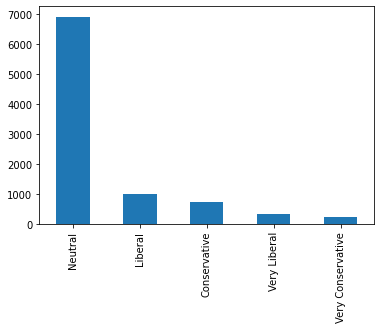

In [12]:
tfdf["label"].value_counts().plot.bar()

In [13]:
tfdf["label"] =  tfdf.apply(lambda row: "Biased" if row["label"]!="Neutral" else "Neutral", axis = 1)
tfdf

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories,text,label
1,http://www.huffingtonpost.com/2013/06/06/ny-ti...,News,1,Civil Rights,National Security,Negative,Neutral,the times became one of the more influential v...,285,-1.0,0.0,Conservative,1,-1,the times became one of the more influential v...,Biased
3,http://www.foxnews.com/opinion/2013/04/23/immi...,Opinion,0,Civil Rights,None,SomewhatNegative,SomewhatPositive,americans believe in the value of immigration....,600,-0.5,0.5,Conservative,1,-1,americans believe in the value of immigration....,Biased
5,http://www.usatoday.com/story/opinion/2013/02/...,other,1,Economy,Economy,Neutral,Neutral,fredric rolando the effort by postmaster gene...,390,0.0,0.0,Neutral,0,0,fredric rolando the effort by postmaster gene...,Neutral
6,http://www.huffingtonpost.com/2013/05/01/pat-t...,Opinion,1,Gun Rights Regulation,None,SomewhatPositive,Negative,sen. pat toomey (r-pa.) revealed that some mem...,398,0.5,-1.0,Very Liberal,1,1,sen. pat toomey (r-pa.) revealed that some mem...,Biased
7,http://www.foxnews.com/us/2013/07/05/terrorist...,News,0,National Security,International News,Neutral,Neutral,a kansas city man and two other aspiring holy ...,600,0.0,0.0,Neutral,0,0,a kansas city man and two other aspiring holy ...,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12342,http://news.yahoo.com/world-welcomes-us-budget...,News,1,Economy,None,Neutral,Neutral,london (ap) — the world's disbelief at the pol...,600,0.0,0.0,Neutral,0,0,london (ap) — the world's disbelief at the pol...,Neutral
12345,http://www.breitbart.com/Big-Journalism/2013/0...,News,0,Education,None,Neutral,Neutral,the mainstream media in the united states have...,295,0.0,0.0,Neutral,0,0,the mainstream media in the united states have...,Neutral
12347,http://news.yahoo.com/nc-protests-split-bibles...,News,0,Civil Rights,None,Neutral,Neutral,"raleigh, n.c. (ap) — over the last two months,...",600,0.0,0.0,Neutral,0,0,"raleigh, n.c. (ap) — over the last two months,...",Neutral
12348,http://www.nytimes.com/2013/12/01/us/politics/...,News,1,Healthcare,None,Neutral,Neutral,when the problems occur — and they still do — ...,386,0.0,0.0,Neutral,0,0,when the problems occur — and they still do — ...,Neutral


<AxesSubplot:>

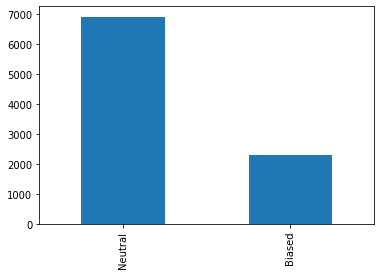

In [14]:
tfdf["label"].value_counts().plot.bar()

In [15]:
biaseddata = tfdf[tfdf['label']=="Biased"]
biaseddata.shape

(2306, 16)

In [16]:
neutraldata = tfdf[tfdf['label']=="Neutral"][:biaseddata.shape[0]]
neutraldata.shape

(2306, 16)

In [17]:
tfdf = pd.concat([biaseddata,neutraldata])
tfdf = tfdf.sample(frac=1)
tfdf

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories,text,label
2475,http://www.latimes.com/news/politics/la-pn-ame...,other,0,None,None,Neutral,Neutral,"washington – americans are exercising more, bu...",600,0.0,0.0,Neutral,0,0,"washington – americans are exercising more, bu...",Neutral
2852,http://www.washingtonpost.com/national/health-...,other,1,None,None,Neutral,Neutral,"bebe bahnsen remembers the night, alone in her...",600,0.0,0.0,Neutral,0,0,"bebe bahnsen remembers the night, alone in her...",Neutral
1922,http://www.foxnews.com/politics/2013/07/08/rep...,News,0,Healthcare,Economy,SomewhatNegative,SomewhatPositive,house republicans are escalating their scrutin...,500,-0.5,0.5,Conservative,1,-1,house republicans are escalating their scrutin...,Biased
187,http://www.foxnews.com/opinion/2013/12/24/army...,News,0,Civil Rights,None,Neutral,Neutral,don’t say christmas. that’s the message that ...,542,0.0,0.0,Neutral,0,0,don’t say christmas. that’s the message that ...,Neutral
8255,http://www.dailykos.com/story/2013/07/15/12238...,Opinion,0,Economy,Education,SomewhatPositive,Negative,sen. marco rubio sen. marco rubio for presid...,439,0.5,-1.0,Very Liberal,1,1,sen. marco rubio sen. marco rubio for presid...,Biased
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7161,http://www.huffingtonpost.com/2013/07/08/gop-w...,News,1,Economy,None,SomewhatPositive,SomewhatNegative,washington -- the house appropriations committ...,600,0.5,-0.5,Liberal,1,1,washington -- the house appropriations committ...,Biased
963,http://www.dailykos.com/story/2013/10/21/12494...,News,0,Economy,Healthcare,Neutral,Neutral,our story so far: those who enroll in medicaid...,600,0.0,0.0,Neutral,0,0,our story so far: those who enroll in medicaid...,Neutral
2086,http://www.breitbart.com/Big-Journalism/2013/0...,Opinion,1,Democrat Scandals,None,Negative,Positive,eight months into president george w. bush’s s...,473,-1.0,1.0,Very Conservative,1,-1,eight months into president george w. bush’s s...,Biased
2997,http://www.foxnews.com/politics/2013/02/03/flo...,News,1,Economy,None,Neutral,Neutral,a florida republican congressman is welcoming ...,395,0.0,0.0,Neutral,0,0,a florida republican congressman is welcoming ...,Neutral


In [18]:
train_section = tfdf[:4000]
val_section = tfdf[4000:4500]
test_section = tfdf[4500:]

# train_section = tfdf[5000:8000]
# val_section = tfdf[8000:9000]
# test_section = tfdf[9000:]

# train_section = tfdf[:10000]
# val_section = tfdf[10000:12500]
# test_section = tfdf[12500:]

<AxesSubplot:>

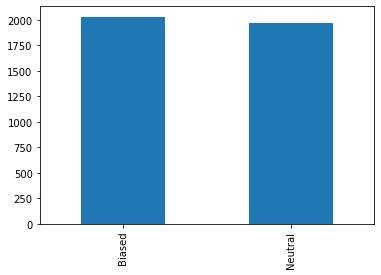

In [20]:
train_section["label"].value_counts().plot.bar()

<AxesSubplot:>

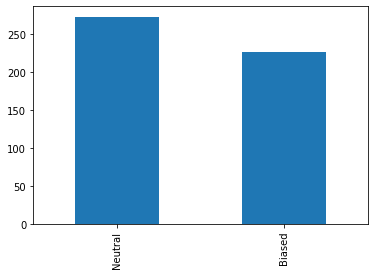

In [21]:
val_section["label"].value_counts().plot.bar()

<AxesSubplot:>

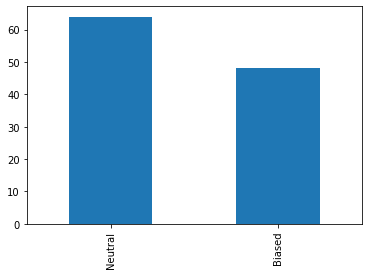

In [22]:
test_section["label"].value_counts().plot.bar()

In [23]:
np.unique(tfdf.label)

array(['Biased', 'Neutral'], dtype=object)

In [5]:
train_section = pd.read_table("train_dataset.csv", sep='\t', index_col=0)
val_section = pd.read_table("val_dataset.csv", sep='\t', index_col=0)
test_section = pd.read_table("test_dataset.csv", sep='\t', index_col=0)

## Hyperparameters

In [6]:
MAX_LEN = 512
nepochs = 50
nbatch = 16

In [7]:
data_dir = "./data"
log_dir = f"{data_dir}/experiments/logs"
save_path = f"{data_dir}/experiments/BinaryXLNetmodels"
cache_path_train = f"{data_dir}/cache/BinaryXLNetmodel.train"
cache_path_test = f"{data_dir}/cache/BinaryXLNetmodel.test"

## Transforming Data

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels = np.asarray(le.fit_transform(train_section['label']))
val_labels = np.asarray(le.transform(val_section['label']))

In [9]:
# le.inverse_transform(val_labels)[:20]

In [10]:
len(np.unique(train_labels))

2

In [29]:
tfdf[tfdf['label']=='Neutral'].shape[0]/tfdf.article.shape[0]

0.5

<AxesSubplot:>

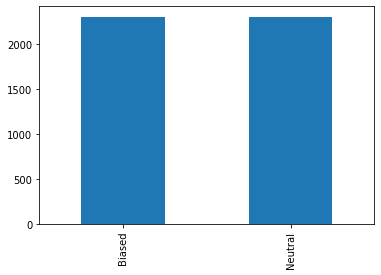

In [30]:
tfdf["label"].value_counts().plot.bar()

In [11]:
tokenizer_transformer = XLNetTokenizer.from_pretrained('xlnet-large-cased')

In [12]:

def create_input_array(df, tokenizer):
    sentences = df.text.values

    input_ids = []
    attention_masks = []
    token_type_ids = []

    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
            sent,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=MAX_LEN,  # Pad & truncate all sentences.
                pad_to_max_length=True,
                return_attention_mask=True,  # Construct attn. masks.
                return_tensors='tf',  # Return tf tensors.
            )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

        token_type_ids.append(encoded_dict['token_type_ids'])

    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    token_type_ids = tf.convert_to_tensor(token_type_ids)


    return input_ids, attention_masks, token_type_ids
#     return input_ids, attention_masks



In [13]:
train_inputs = [create_input_array(train_section, tokenizer=tokenizer_transformer)]
val_inputs = [create_input_array(val_section, tokenizer=tokenizer_transformer)]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2068: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
def convert_inputs_to_tf_dataset(inputs):
    # args.max_seq_len = 256
    ids = inputs[0][0]
    masks = inputs[0][1]
    token_types = inputs[0][2]

    ids = tf.reshape(ids, (-1, MAX_LEN))
    print("Input ids shape: ", ids.shape)
    masks = tf.reshape(masks, (-1, MAX_LEN))
    print("Input Masks shape: ", masks.shape)
    token_types = tf.reshape(token_types, (-1, MAX_LEN))
    print("Token type ids shape: ", token_types.shape)

    ids=ids.numpy()
    masks = masks.numpy()
    token_types = token_types.numpy()
#     return[ids]
#     return [ids, masks, token_types]
    return [ids, masks]

In [15]:
train_data = convert_inputs_to_tf_dataset(train_inputs)
val_data = convert_inputs_to_tf_dataset(val_inputs)

Input ids shape:  (4000, 512)
Input Masks shape:  (4000, 512)
Token type ids shape:  (4000, 512)
Input ids shape:  (500, 512)
Input Masks shape:  (500, 512)
Token type ids shape:  (500, 512)


In [16]:
train_data

[array([[11048,   577,    17, ...,  1841,     4,     3],
        [   39,  1156,    17, ...,    89,     4,     3],
        [  480, 23785,    23, ...,  6420,     4,     3],
        ...,
        [11048,   577,    17, ...,  4419,     4,     3],
        [   17,    83, 17273, ...,  1674,     4,     3],
        [    5,     5,     5, ...,     9,     4,     3]], dtype=int32),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]], dtype=int32)]

In [17]:
model = TFXLNetForSequenceClassification.from_pretrained("xlnet-large-cased", num_labels=len(np.unique(train_labels)))


Some layers from the model checkpoint at xlnet-large-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-large-cased and are newly initialized: ['sequence_summary', 'logits_proj']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
model.summary()

Model: "tfxl_net_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFXLNetMainLaye multiple                  360268800 
_________________________________________________________________
sequence_summary (TFSequence multiple                  1049600   
_________________________________________________________________
logits_proj (Dense)          multiple                  2050      
Total params: 361,320,450
Trainable params: 361,320,450
Non-trainable params: 0
_________________________________________________________________


In [19]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-07, epsilon=1e-08)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history = model.fit(x = train_data, 
          y = train_labels,
          validation_data= (val_data, val_labels), 
          epochs = 25, 
          batch_size = 5)

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - 692s 843ms/step - loss: 0.7360 - accuracy: 0.4875 - val_loss: 0.6805 - val_accuracy: 0.5680
Epoch 2/25
800/800 [==============================] - 678s 847ms/step - loss: 0.6952 - accuracy: 0.5317 - val_lo

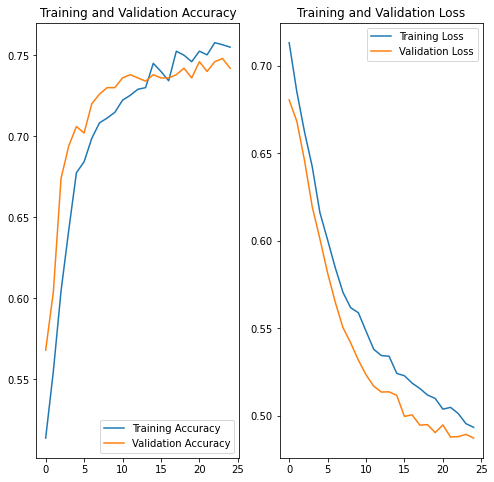

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
# plt.show()
plt.savefig('xlnetlargebinary.jpg')

In [21]:
xlnetmodeldata = pd.DataFrame(list(zip(acc, val_acc, loss, val_loss)),
               columns =['Accuracy', 'ValAccuracy', 'Loss', 'Val_loss'])
xlnetmodeldata.head()

,Accuracy,ValAccuracy,Loss,Val_loss
0,0.51375,0.568,0.713227,0.680530
1,0.55500,0.604,0.685114,0.668284
2,0.60450,0.674,0.662209,0.645876
3,0.64200,0.694,0.642402,0.619509
4,0.67750,0.706,0.616118,0.601092


In [22]:
xlnetmodeldata.to_csv("xlnetmodeldata.csv", sep='\t')

In [23]:
test_section.shape

(110, 16)

In [24]:
test_section = test_section[:110]
test_section.shape

(110, 16)

In [25]:
test_labels = np.asarray(le.transform(test_section['label']))
test_inputs = [create_input_array(test_section, tokenizer=tokenizer_transformer)]
test_data = convert_inputs_to_tf_dataset(test_inputs)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2068: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Input ids shape:  (110, 512)
Input Masks shape:  (110, 512)
Token type ids shape:  (110, 512)


In [35]:
print("Evaluate on test data")
results = model.evaluate(test_data, test_labels, batch_size=5)
print("test loss, test acc:", results)


Evaluate on test data
22/22 [==============================] - 4s 177ms/step - loss: 0.4462 - accuracy: 0.8091
test loss, test acc: [0.44617000222206116, 0.8090909123420715]


In [42]:
testmodel = TFXLNetForSequenceClassification.from_pretrained("data/experiments/BinaryXLNetmodels", num_labels=len(np.unique(train_labels)))


All model checkpoint layers were used when initializing TFXLNetForSequenceClassification.

All the layers of TFXLNetForSequenceClassification were initialized from the model checkpoint at data/experiments/BinaryXLNetmodels.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetForSequenceClassification for predictions without further training.


In [46]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-07, epsilon=1e-08)

testmodel.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [26]:
# predict probabilities for test set
test_probs = model.predict(test_data, batch_size= 1, verbose=0)

In [27]:
test_probs = test_probs["logits"]

In [28]:
test_classes = np.argmax(test_probs, axis = 1)

In [29]:
test_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0])

In [30]:
test_labels

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0])

In [31]:
c=0
for i in range(test_classes.shape[0]):
    if test_classes[i]==test_labels[i]:
        c+=1
print("Test accuracy:")
print(c/test_labels.shape[0])

Test accuracy:
0.8090909090909091


In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [33]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, test_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_labels, test_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_labels, test_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, test_classes)
print('F1 score: %f' % f1)
 

Accuracy: 0.809091
Precision: 0.805970
Recall: 0.870968
F1 score: 0.837209


In [71]:
train_section.to_csv("train_dataset.csv", sep='\t')
val_section.to_csv("val_dataset.csv", sep='\t')
test_section.to_csv("test_dataset.csv", sep='\t')

In [34]:
model.save_pretrained(save_path)

In [77]:
tf.keras.backend.clear_session()